## This notebook demonstrates how to use bias mitigation algorithm during "Post-processing stage" from AI 360 fairness toolkit

### Post-processing algorithm
A bias mitigation algorithm that is applied to predicted labels.

### Insert your credentials as credentials in the below cell
Click on dropdown from Pipeline_LabelEncoder-0.1.zip under Data tab and select 'Credentials'

In [2]:
from ibm_botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

In [3]:
import os
os.getcwd()

'/home/wsuser/work'

In [4]:
cos.download_file(Bucket=credentials['BUCKET'],Key='Pipeline_LabelEncoder-0.1.zip',Filename='/home/wsuser/work/Pipeline_LabelEncoder-0.1.zip')

In [5]:
!ls

Pipeline_LabelEncoder-0.1.zip


In [6]:
!pip install Pipeline_LabelEncoder-0.1.zip
!pip install aif360
!pip install fairlearn

Processing ./Pipeline_LabelEncoder-0.1.zip
  Created wheel for Pipeline-LabelEncoder: filename=Pipeline_LabelEncoder-0.1-py3-none-any.whl size=2062 sha256=ca70e060b2091f8204a7377e68a004e429d9e435e77d79d6577cd377e78125ab
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/6b/4b/1e/43f3c8b97ffade4539a329b9eaa5755e4df16a248960947534
Successfully built Pipeline-LabelEncoder
  Attempting uninstall: Pipeline-LabelEncoder
    Found existing installation: Pipeline-LabelEncoder 0.1
    Uninstalling Pipeline-LabelEncoder-0.1:
      Successfully uninstalled Pipeline-LabelEncoder-0.1


In [7]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.__version__

'2.4.4'

In [8]:
%matplotlib inline
# Load all necessary packages
import numpy as np
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Insert the data as Pandas Dataframe and change the name from df_data_ to df

,Gender,Married,Education,Fraud_risk
0,Male,No,1,Risk
1,Male,Yes,1,Safe
2,Male,Yes,1,Safe
3,Male,Yes,0,Safe
4,Male,No,1,Risk


In [10]:
df.describe(include = 'all')

,Gender,Married,Education,Fraud_risk
count,921,921,921.000000,921
unique,2,2,NaN,2
top,Male,No,NaN,Safe
freq,703,501,NaN,562
mean,NaN,NaN,0.730727,NaN
std,NaN,NaN,0.443823,NaN
min,NaN,NaN,0.000000,NaN
25%,NaN,NaN,0.000000,NaN
50%,NaN,NaN,1.000000,NaN
75%,NaN,NaN,1.000000,NaN


In [11]:
privileged_groups = [{'Gender': 1}]
unprivileged_groups = [{'Gender': 0}]
cost_constraint='weighted'
favorable_label = 1 
unfavorable_label = 0

In [12]:
from sklearn import preprocessing
categorical_column = ['Gender', 'Married', 'Fraud_risk']

data_encoded = df.copy(deep=True)
#Use Scikit-learn label encoding to encode character data
lab_enc = preprocessing.LabelEncoder()
for col in categorical_column:
        data_encoded[col] = lab_enc.fit_transform(df[col])
        le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
        print('Feature', col)
        print('mapping', le_name_mapping)
        

data_encoded.head()

Feature Gender
mapping {'Female': 0, 'Male': 1}
Feature Married
mapping {'No': 0, 'Yes': 1}
Feature Fraud_risk
mapping {'Risk': 0, 'Safe': 1}


,Gender,Married,Education,Fraud_risk
0,1,0,1,0
1,1,1,1,1
2,1,1,1,1
3,1,1,0,1
4,1,0,1,0


In [13]:
!pip install Pipeline_LabelEncoder-0.1.zip

Processing ./Pipeline_LabelEncoder-0.1.zip
  Created wheel for Pipeline-LabelEncoder: filename=Pipeline_LabelEncoder-0.1-py3-none-any.whl size=2062 sha256=7c148783d4f7fad1b0f928863dd159e80e0f76c02298408db5b5bd44b7d0e78a
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/6b/4b/1e/43f3c8b97ffade4539a329b9eaa5755e4df16a248960947534
Successfully built Pipeline-LabelEncoder
  Attempting uninstall: Pipeline-LabelEncoder
    Found existing installation: Pipeline-LabelEncoder 0.1
    Uninstalling Pipeline-LabelEncoder-0.1:
      Successfully uninstalled Pipeline-LabelEncoder-0.1


In [14]:
from Pipeline_LabelEncoder.sklearn_label_encoder import PipelineLabelEncoder
preprocessed_data = PipelineLabelEncoder(columns = ['Gender','Married', 'Fraud_risk']).fit_transform(data_encoded)
print('-------------------------')
#print('validation data encoding')
#validation_enc_data = PipelineLabelEncoder(columns = ['Gender','Married', 'Fraud_risk']).transform(validation_input_data)

Inside fit transform
Feature Gender
mapping {0: 0, 1: 1}
Feature Married
mapping {0: 0, 1: 1}
Feature Fraud_risk
mapping {0: 0, 1: 1}
-------------------------


In [15]:
#Create binary label dataset that can be used by bias mitigation algorithms
fraud_dataset = BinaryLabelDataset(favorable_label=favorable_label,
                                unfavorable_label=unfavorable_label,
                                df=preprocessed_data,
                                label_names=['Fraud_risk'],
                                protected_attribute_names=['Gender', 'Married'],
                                unprivileged_protected_attributes=unprivileged_groups)

In [16]:
dataset_orig_train, dataset_orig_vt = fraud_dataset.split([0.6], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

### Training data characteristics

In [17]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Dataset shape

(552, 3)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Gender', 'Married']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['Gender', 'Married', 'Education']


### Metric for the original datasets (without any classifiers)

In [18]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_valid = BinaryLabelDatasetMetric(dataset_orig_valid, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original validation dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_valid.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.335727


#### Original validation dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.396668


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.460317


### Train classifier (logistic regression on original training data)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
lmod = LogisticRegression()
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = scale_orig.transform(dataset_orig_valid.features)
y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

X_test = scale_orig.transform(dataset_orig_test.features)
y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

### Results before post-processing

In [20]:
cm_pred_train = ClassificationMetric(dataset_orig_train, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(dataset_orig_valid, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
-0.18984395152026312
Difference in GFNR between unprivileged and privileged groups
0.20564974255683074


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.21128922832410973
Difference in GFNR between unprivileged and privileged groups
0.19262371319267885


#### Original-Predicted testing dataset

Difference in GFPR between unprivileged and privileged groups
-0.21800999378346622
Difference in GFNR between unprivileged and privileged groups
0.170629864716808


### Perform odds equalizing post processing on scores

In [21]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=None)
cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

### Transform validation and test data using the post processing algorithm

In [22]:
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

### Results after post-processing

In [23]:
cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.22387251471792324
Difference in GFNR between unprivileged and privileged groups
0.17486203209269477


#### Original-Transformed testing dataset

Difference in GFPR between unprivileged and privileged groups
-0.21800999378346622
Difference in GFNR between unprivileged and privileged groups
0.16020525050725246


### Testing: Check if the rates for validation data has gone down after transformation

In [24]:
print(np.abs(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate)))
print(np.abs(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate)))

0.19262371319267885
0.17486203209269477


In [25]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
                                     dataset_orig_valid, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))


#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [00:00<00:00, 115.97it/s]


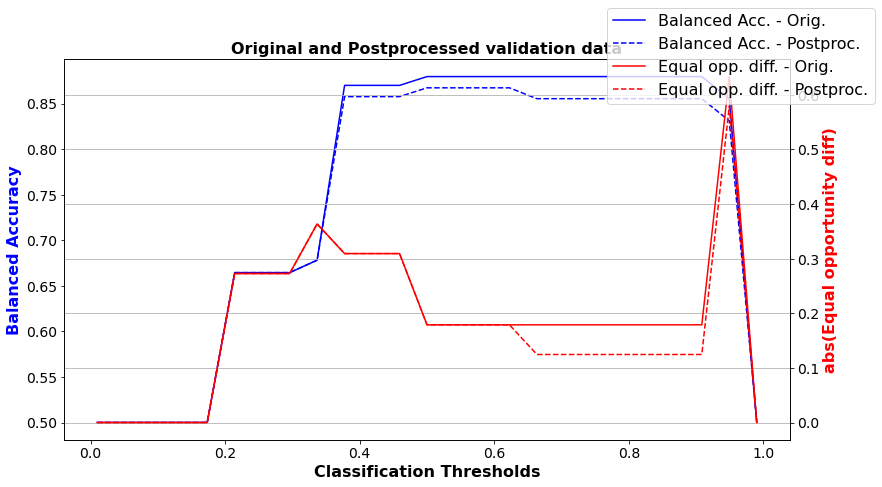

In [26]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)

### We have observed how the predicted labels are modified to eliminate the bias

In [27]:
print(bef_bal_acc_valid)

[0.5        0.5        0.5        0.5        0.5        0.66444924
 0.66444924 0.66444924 0.67811339 0.86989093 0.86989093 0.86989093
 0.87953973 0.87953973 0.87953973 0.87953973 0.87953973 0.87953973
 0.87953973 0.87953973 0.87953973 0.87953973 0.87953973 0.85526789
 0.5       ]


In [28]:
print(aft_bal_acc_valid)

[0.5        0.5        0.5        0.5        0.5        0.66444924
 0.66444924 0.66444924 0.67811339 0.85754525 0.85754525 0.85754525
 0.86719405 0.86719405 0.86719405 0.86719405 0.85526789 0.85526789
 0.85526789 0.85526789 0.85526789 0.85526789 0.85526789 0.83099604
 0.5       ]


In [29]:
print(bef_avg_odds_diff_valid)

[ 0.          0.          0.          0.          0.         -0.27272727
 -0.27272727 -0.27272727 -0.36363636 -0.30928854 -0.30928854 -0.30928854
 -0.17885375 -0.17885375 -0.17885375 -0.17885375 -0.17885375 -0.17885375
 -0.17885375 -0.17885375 -0.17885375 -0.17885375 -0.17885375 -0.63339921
  0.        ]


In [30]:
print(aft_avg_odds_diff_valid)

[ 0.          0.          0.          0.          0.         -0.27272727
 -0.27272727 -0.27272727 -0.36363636 -0.30928854 -0.30928854 -0.30928854
 -0.17885375 -0.17885375 -0.17885375 -0.17885375 -0.12450593 -0.12450593
 -0.12450593 -0.12450593 -0.12450593 -0.12450593 -0.12450593 -0.57905138
  0.        ]
